# Paper

Attempt to reproduce results of **"5.3 Prediction experiments on synthetic data (page 2759)"** from paper [Gaussian processes with
multidimensional distribution inputs via
optimal transport and Hilbertian
embedding](https://projecteuclid.org/journalArticle/Download?urlId=10.1214%2F20-EJS1725)

In [ ]:
!pip install ott-jax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 132 kB 35.9 MB/s 


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,9)

In [ ]:
import numpy as onp
import jax
import jax.numpy as jnp

def targets_ground_truth(points, sigmas):
  m1, m2 = points[:,0], points[:,1]
  targets = (m1 - m2**2) / (1 + jnp.squeeze(sigmas))
  return targets

def generate_meta_dataset(key, ds_size, sigmas_bounds):
  key_1, key_2 = jax.random.split(key)
  min_sigma, max_sigma = sigmas_bounds
  means = jax.random.uniform(key_1, shape=(ds_size, 2), minval=0.2, maxval=0.8)
  sigmas = jax.random.uniform(key_2, shape=(ds_size, 1), minval=min_sigma, maxval=max_sigma)
  targets = targets_ground_truth(means, sigmas)
  return targets, (means, sigmas)

def generate_sample_dataset(key, ds_size, num_points, sigmas_bounds):
  key_1, key_2 = jax.random.split(key)
  targets, (means, sigmas) = generate_meta_dataset(key_1, ds_size, sigmas_bounds)
  sample = means[:,jnp.newaxis,:] + jax.random.normal(key_2, shape=(ds_size, num_points, 2)) * sigmas[:,jnp.newaxis,:]
  return sample, targets

def generate_grid_dataset(key, ds_size, num_points, sigmas_bounds):
  key_1, key_2 = jax.random.split(key)
  targets, (means, sigmas) = generate_meta_dataset(key_1, ds_size, sigmas_bounds)
  normal_pdf = jax.scipy.stats.norm.pdf
  pdfs = normal_pdf(means, sigmas)
  # TODO: fixme
  return sample, targets

In [ ]:
# For explicit discretization approach:
# 
# Default: how to discretize ? Not easy. Weight = 0 on most pixels of the grid ? (it depends of sigma).

In [ ]:
key = jax.random.PRNGKey(61378)
ds_size = 100
num_points = 50 * 50
min_sigma = 0.01
max_sigma = 0.02 
sample_ds, target_ds = generate_sample_dataset(key, ds_size, num_points, (min_sigma, max_sigma))

In [ ]:
from sklearn.model_selection import train_test_split
sample_train, sample_test, target_train, target_test = train_test_split(sample_ds, target_ds, test_size=0.5, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt
import ott
from ott.core.sinkhorn import sinkhorn

resolution = 50
x_thicks = jnp.linspace(0, 1, resolution)
y_thicks = jnp.linspace(0, 1, resolution)
x_grid, y_grid = jnp.meshgrid(x_thicks, y_thicks)
grid = jnp.stack([x_grid.ravel(), y_grid.ravel()], axis=-1)

In [ ]:
def plot_ground_truth(sigmas):
  targets_grid = targets_ground_truth(grid, sigmas)
  plt.imshow(targets_grid.reshape((resolution, resolution)), origin='lower')

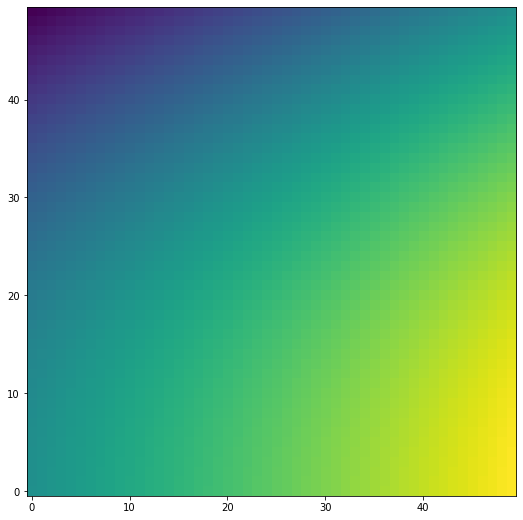

In [ ]:
plot_ground_truth(min_sigma)

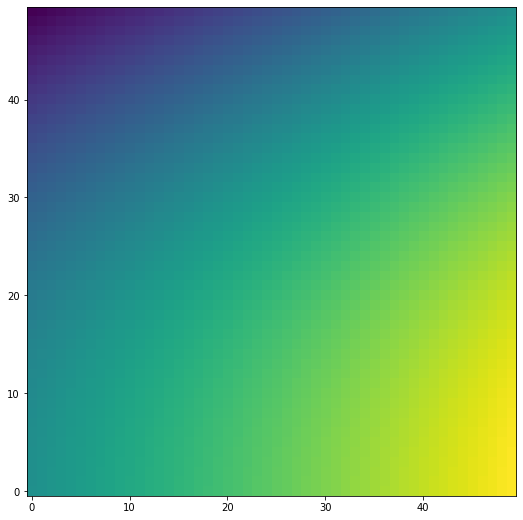

In [ ]:
plot_ground_truth(max_sigma)

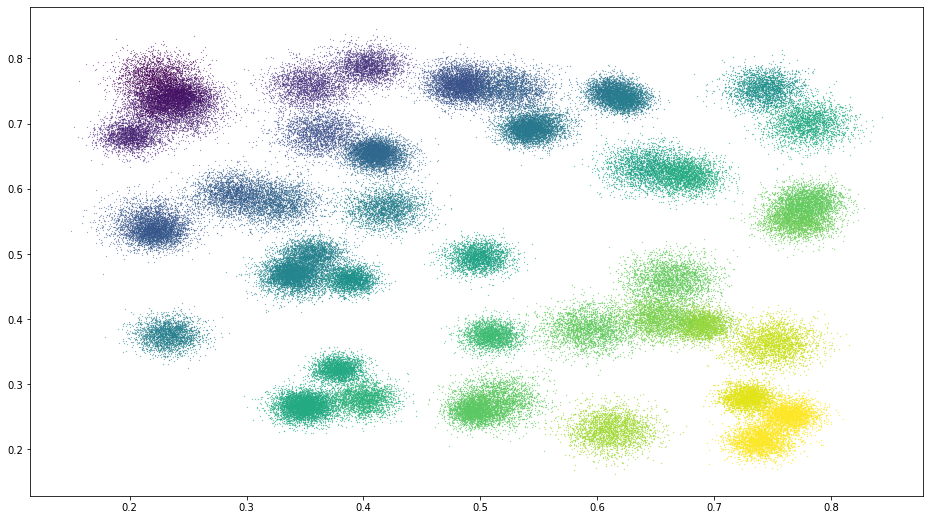

In [ ]:
import matplotlib.cm as cm

def plot_ds(sample_train, target_train):
  min_sample, max_sample = target_train.min(), target_train.max()
  for sample, target in zip(sample_train, target_train):
    r = (target - min_sample) / (max_sample - min_sample)
    color = cm.viridis(r)
    s = jnp.exp(target) / 20
    plt.scatter(sample[:,0], sample[:,1], s=s, color=color)
plot_ds(sample_train, target_train)

In [ ]:
from ott.geometry import PointCloud
import tqdm

@jax.jit
def generate_embedding(points, mu, epsilon):
  geom = PointCloud(points, mu, epsilon=epsilon)
  ot_sol = sinkhorn(geom)
  return ot_sol

def generate_embeddings(sample_ds, mu, epsilon):
  pbar = tqdm.tqdm(total=len(sample_ds))
  converged_hist = []
  features = []
  for sample in sample_ds:
    ot_sol = generate_embedding(sample, mu, epsilon)
    feature = ot_sol.g
    features.append(feature)
    converged_hist.append(ot_sol.converged)
    pbar.set_postfix({'converged':jnp.mean(jnp.array(converged_hist))})
    pbar.update()
  return jnp.stack(features)

In [ ]:
epsilon = 1e-3
g_train = generate_embeddings(sample_train, grid, epsilon)
g_test = generate_embeddings(sample_test, grid, epsilon)

100%|██████████| 50/50 [05:36<00:00,  6.72s/it, converged=1.0]


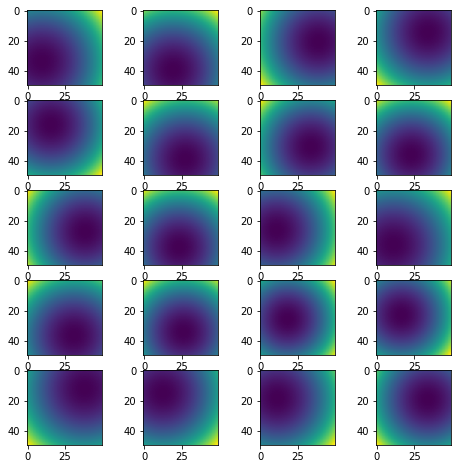

In [ ]:
def visualize_embedding(features, columns = 4, rows = 5):
  fig = plt.figure(figsize=(8, 8))
  for i, img in zip(range(1, columns*rows +1), features):
      fig.add_subplot(rows, columns, i)
      plt.imshow(img.reshape((resolution, resolution)))
  fig.show()
visualize_embedding(g_train)

In [ ]:
def gamma_standardizer(train_samples, test_samples):
    # pre-process features: imit scaler of sklearn.svm behavior
    # it helps with numerical errors of RBF kernel in high dimensional space (not ideal for GP)
    mean_train_samples = train_samples.mean()
    sigma_train_samples = train_samples.std()**2 * train_samples.shape[-1]
    train_samples = (train_samples - mean_train_samples) / sigma_train_samples
    test_samples = (test_samples - mean_train_samples) / sigma_train_samples
    return train_samples, test_samples

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.gaussian_process.kernels import ConstantKernel, RBF

def gp_learning(train_samples, train_targets, test_samples, test_targets,
                with_mean=True, with_std=True, verbose=0, **kwargs):
    kernel = ConstantKernel(1.0) * RBF(1.0) + ConstantKernel(0.0)
    pipeline = Pipeline([('scaler', StandardScaler(with_mean=with_mean, with_std=with_std)),
                         ('gpr', GaussianProcessRegressor(kernel=kernel, **kwargs))])
    pipeline = pipeline.fit(onp.array(train_samples).astype(onp.float64), onp.array(train_targets).astype(onp.float64))
    test_pred = pipeline.predict(test_samples)
    evs = explained_variance_score(test_targets, test_pred)
    rmse = mean_squared_error(test_targets, test_pred, squared=False)
    mae = mean_absolute_error(test_targets, test_pred)
    if verbose:
      msg = f"TrainSetSize={len(train_samples)} mae={mae:.5f} rmse={rmse:.5f} evs={evs:.5f}"
      print(msg)
    infos = dict(train_set_size=len(train_samples), mae=mae, rmse=rmse, evs=evs)
    return pipeline, infos

In [ ]:
def convergence_speed(test_bounds, g_train, target_train, g_test, target_test):
  infos = []
  for i in range(1, len(g_train_standard)):
    gp, infos_row = gp_learning(g_train[:i], target_train[:i], g_test, target_test,
                            with_mean=False, with_std=False,
                            n_restarts_optimizer=10, normalize_y=True)
    infos.append(infos_row)
  infos = pd.DataFrame(infos)
  return infos

In [ ]:
# without standardization
gp, infos = gp_learning(g_train, target_train, g_test, target_test,
            with_mean=False, with_std=False,
            n_restarts_optimizer=10, normalize_y=False, alpha=1e-3)
infos, gp['gpr'].kernel_, gp['gpr'].alpha_

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


({'evs': 0.9997372181428964,
  'mae': 0.0031801989551993115,
  'rmse': 0.004092022417094532,
  'train_set_size': 50},
 0.861**2 * RBF(length_scale=37.1) + 0.00316**2,
 array([  1.57417553,  -7.42844172,   2.87814086,  -4.39971304,
          2.24162803,  -6.61763414,   3.50599717,  -3.96100335,
          6.11735058,  -2.15869835,   7.89997682,  -3.23227724,
          0.52948033,   2.55429613,   0.61519051,   1.69656154,
          7.80380581,  -0.53435415,   3.6440929 ,   5.01149811,
          2.28338972,  -3.46638287,  -0.26711556,  -4.98067245,
          0.6584687 ,  -4.13517607,  -6.28033493,   2.98339807,
          1.44388895,  -2.22513542,  -3.64134511,  -2.6754163 ,
          3.07849113,   3.09309486,  -0.33987712,  -0.09900963,
          1.02571868,   3.75160836, -10.25503133,   1.1626268 ,
          4.84886369,   2.32585435,   2.51234549,  -2.96363225,
         -2.03064078,   3.59829321,  -0.08074444,  -5.58620471,
         -3.65427439,   2.30467457]))

In [ ]:
import pandas as pd

# with standardization
g_train_standard, g_test_standard = gamma_standardizer(g_train, g_test)
gp, infos = gp_learning(g_train_standard, target_train, g_test_standard, target_test,
                        with_mean=False, with_std=False,
                        n_restarts_optimizer=10, normalize_y=False, alpha=1e-2)
infos, gp['gpr'].kernel_, gp['gpr'].alpha_

/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:285: RuntimeWarning: divide by zero encountered in log
  return np.log(np.hstack(theta))
/usr/local/lib/python3.7/dist-packages/sklearn/gaussian_process/kernels.py:427: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  ConvergenceWarning,


({'evs': 0.9978474935317414,
  'mae': 0.009522788435306075,
  'rmse': 0.011705577264329914,
  'train_set_size': 50},
 0.752**2 * RBF(length_scale=0.4) + 0.00316**2,
 array([-0.01007617, -2.79422064,  2.02890477, -0.35487808,  0.14493501,
        -2.17269994,  1.06412546, -1.20171941,  2.47367578, -1.60100731,
         1.91022108, -1.01499405, -0.62752117, -0.17653927,  0.7519538 ,
         0.88724912,  1.71545218, -0.04107807,  1.13370403,  1.20660774,
         0.20807775, -1.14935839, -0.08121041, -1.93797118, -0.2839    ,
        -0.53161812, -1.08822822,  1.00357084,  0.10961292,  0.01807377,
        -1.56917122, -0.19524703,  1.51788475,  0.58595197,  0.37119346,
         0.45378086, -0.0521565 ,  0.2269008 , -2.79439065,  1.34162967,
         0.9852357 ,  0.64357782,  1.41310048, -0.22518305, -1.02147716,
         1.10368928,  0.77059609, -1.78287986, -1.68040176,  0.62812269]))

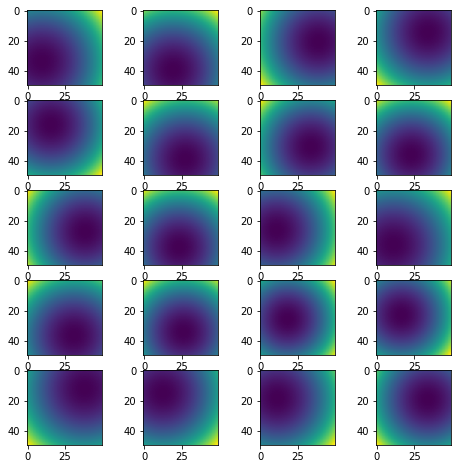

In [ ]:
visualize_embedding(g_train_standard)